In [3]:
import os

datadir = os.path.join('data')
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'

In [4]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    columns_to_drop.extend(ds.filter(regex='.*/tool').columns)
    columns_to_drop.extend(ds.filter(regex='.*/tool/spm').columns)
    ds = ds.drop(columns=columns_to_drop)
    return ds

In [5]:
dataset = pd.read_csv(ds_path, delimiter=';')
normalized_dataset = normalize_dataset(dataset)

print(f"{len(normalized_dataset)} configs in dataset")

normalized_dataset.to_csv(os.path.join(datadir, f'normalized_dataset.csv'), index=False, sep=';')

normalized_dataset.head(1010)

1001 configs in dataset


,slice_timing_correction/ref_slice/middle,distorsion_correction,signal_modeling/temporal_noise_autocorrelation/FAST,slice_timing_correction,signal_modeling/temporal_noise_autocorrelation/AR1,spatial_normalization/algorithm/linear,motion_correction_realignment/register_to/mean,signal_modeling/hrf/temporal_derivs,spatial_normalization/algorithm/DARTEL,signal_modeling/hrf/canonical,...,spatial_normalization/bias_fwhm,spatial_smoothing/fwhm,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/interpolation/bspline,id,pearson_from_ref,spearman_from_ref,pearson_from_mean,spearman_from_mean
0,False,False,True,False,False,False,True,True,False,False,...,0,6,False,False,False,d73e0359ec51c3b847656b8f2bc157b083dae2057d53a4...,0.103517,0.082454,0.263128,0.245781
1,False,False,True,True,False,False,False,False,False,True,...,0,6,True,False,False,e012bd4d9bab5a18593441c76f48ccc732bca3390703ff...,0.149047,0.124797,0.337434,0.305455
2,True,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,850e4d92a370900eede8982155772f1ba014ab468eef7c...,0.956003,0.882291,0.85473,0.697912
3,False,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,84c27a9d96a41f520b1de0bf3ef88093bcf9761b45e45e...,0.724838,0.58865,0.760644,0.584104
4,False,False,True,True,False,False,True,False,False,False,...,0,6,True,False,False,0c7beba1bec8f4ff1c5ebff7e2af248230c4ce91c27775...,0.095768,0.074215,0.272972,0.252439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,True,False,False,True,True,False,True,False,False,False,...,0,6,True,False,False,478226e8b91fd9e223848097af04e9841a0c7c8bebe003...,0.900571,0.798534,0.815145,0.667142
997,False,False,False,False,True,False,True,True,False,False,...,0,6,False,False,False,49b2e420e59aac429dbf460a5814461a2b645eb20f2387...,0.872822,0.767594,0.786408,0.635235
998,False,False,False,True,True,False,False,False,False,True,...,0,6,False,False,True,2a1e8f3ad608486da7eb9f165fa6389c641a895232a3dc...,0.657927,0.548311,0.758439,0.600097
999,True,False,True,True,False,False,True,False,False,True,...,0,6,False,False,False,cd5f0844e445d6ab574976706eb2929d22072940c7433e...,0.562473,0.446034,0.774017,0.610582


In [9]:

import pandas as pd

correlations = pd.read_csv(corr_path, delimiter=';')
print(f"{len(correlations)} correlations in matrix")

1004004 correlations in matrix


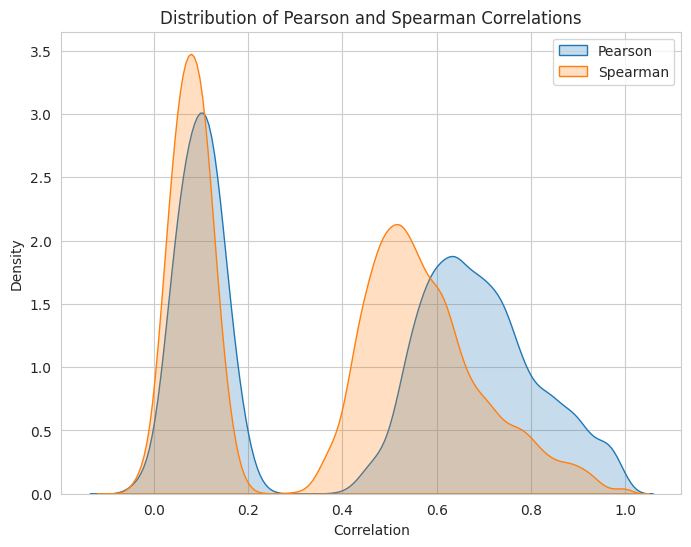

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution of Pearson and Spearman Correlations")
plt.legend()
plt.show()